# Question 1

The correlation coefficient p_ij , defined as the Pearson correlation between log-normalized returns, is bounded between −1 and 1. These bounds reflect the strength and direction of linear relationships between the time series of two stocks.

* p_ij = 1 -> perfect postiive correlation (stocks move in sync)
* p_ij = -1 -> perfect negative correlation (stocks move oppositely)
* p_ij = 0 -> no linear correlation

Log-normalized returns  r_i(t) = log(1 + q_i(t))  are preferred over simple returns for several reasons:

1. Additivity: Log-returns can be summed across time intervals, enabling consistent aggregation when analyzing weekly or monthly data. This is not possible with simple returns.

2. Statistical Normality: Log-returns tend to be more symmetrically distributed and closer to Gaussian, which improves the reliability of correlation estimates. This is especially important since the Pearson correlation assumes linearity and approximate normality.

3. Scale Invariance: Log-returns normalize price changes, allowing meaningful comparisons across stocks regardless of their price levels — critical when constructing a unified correlation graph.

4. Balanced Interpretation of Gains/Losses: Log-returns treat upward and downward movements more symmetrically than simple returns, avoiding skewed effects and ensuring unbiased measurement of volatility and co-movement.

These advantages make log-normalized returns the appropriate choice for correlation-based graph construction and clustering of stock behaviors over different time scales.

# Question 2

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

# Path to the folder with stock CSVs
data_dir = "/content/drive/MyDrive/finance_data/data"

In [7]:
# Helper: compute log returns from Close prices
def get_log_returns(file_path):
    df = pd.read_csv(file_path)
    df = df.sort_values("Date")
    prices = df["Close"].values
    log_returns = np.diff(np.log(prices))
    return log_returns

# List all CSVs
stock_files = glob(os.path.join(data_dir, "*.csv"))
stock_names = [os.path.basename(f).replace(".csv", "") for f in stock_files]

# Get shortest common time series length
min_len = min(len(get_log_returns(f)) for f in stock_files)

# Collect aligned log return series
log_return_list = [get_log_returns(f)[:min_len] for f in stock_files]
log_return_matrix = np.column_stack(log_return_list)
log_return_df = pd.DataFrame(log_return_matrix, columns=stock_names)

In [9]:
# Pearson correlation between columns
cor_matrix = log_return_df.corr().values  # ρ_ij

# Convert to edge weights using: w_ij = sqrt(2(1 - ρ_ij))
weight_matrix = np.sqrt(2 * (1 - cor_matrix))

# Upper triangle only (excluding diagonal as self edges are not meaningful)
upper_tri_indices = np.triu_indices_from(weight_matrix, k=1)
edge_weights = weight_matrix[upper_tri_indices]

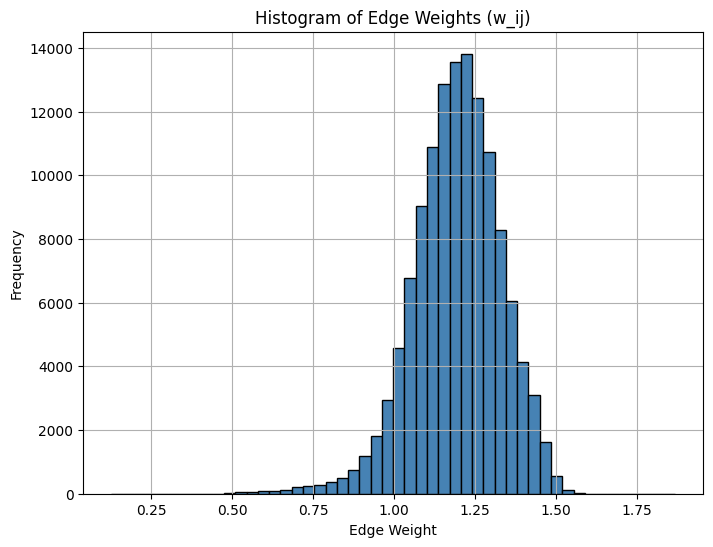

In [ ]:
# Histogram of edge weights
plt.figure(figsize=(8, 6))
plt.hist(edge_weights, bins=50, color="steelblue", edgecolor="black")
plt.title("Histogram of Edge Weights (w_ij)")
plt.xlabel("Edge Weight")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

The histogram of edge weights w_ij reveals that most stock pairs exhibit moderate positive correlation, with weights peaking around 1.2 (equivalent to  p_ij ≅ 0.3 ).

Very few stock pairs are highly correlated ( w_ij < 0.75 ) or strongly anti-correlated ( w_ij > 1.7 ), suggesting that most stocks move somewhat independently, especially across sectors.

This pattern is consistent with a diversified market where sector-specific or macroeconomic factors induce partial co-movement, while many stocks remain relatively uncorrelated.

# Question 3

In [5]:
# Path to Name_sector.csv
sector_file = "/content/drive/MyDrive/finance_data/Name_sector.csv"

# Load sector mapping
sector_df = pd.read_csv(sector_file)
sector_map = dict(zip(sector_df["Symbol"], sector_df["Sector"]))

In [10]:
import networkx as nx

# Create undirected graph with edge weights
G = nx.Graph()

# Add nodes with sector as attribute
for stock in stock_names:
    sector = sector_map.get(stock, "Unknown")
    G.add_node(stock, sector=sector)

# Add edges with computed weights
for i in range(len(stock_names)):
    for j in range(i + 1, len(stock_names)):
        G.add_edge(stock_names[i], stock_names[j], weight=weight_matrix[i, j])

# Extract the Minimum Spanning Tree (MST)
mst = nx.minimum_spanning_tree(G, weight='weight')

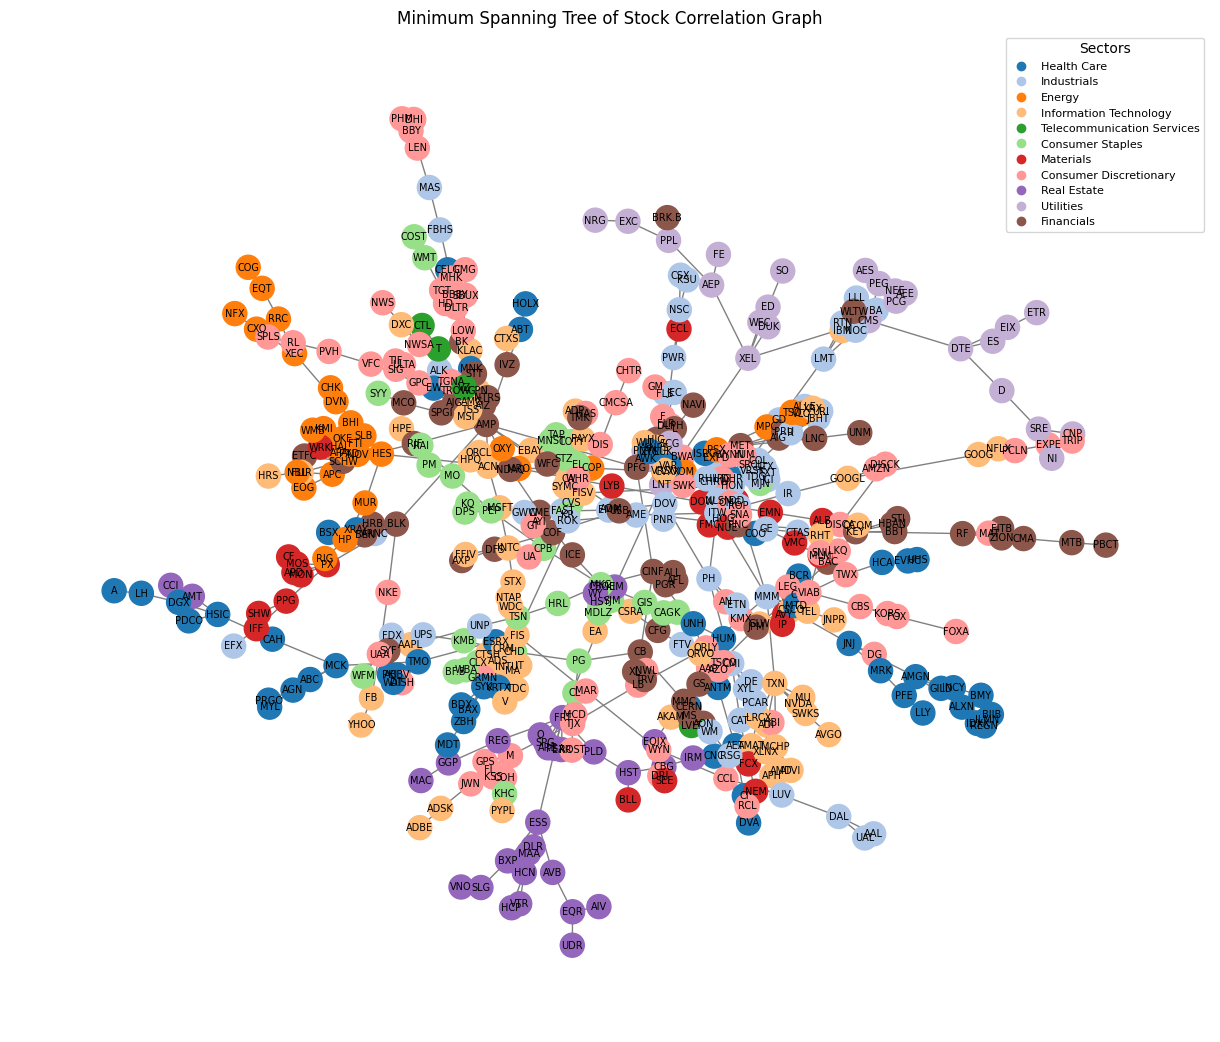

In [11]:
import matplotlib.pyplot as plt

# Assign unique color per sector
sectors = list(set(nx.get_node_attributes(mst, 'sector').values()))
sector_colors = {sector: plt.cm.tab20(i % 20) for i, sector in enumerate(sectors)}

# Node colors based on sector
node_colors = [sector_colors[mst.nodes[n]['sector']] for n in mst.nodes()]

# Layout for tree (can also try spring_layout or kamada_kawai_layout)
pos = nx.spring_layout(mst, seed=42)

plt.figure(figsize=(12, 10))
nx.draw(mst, pos,
        with_labels=True,
        node_color=node_colors,
        node_size=300,
        edge_color='gray',
        font_size=7)

# Legend
for sec in sector_colors:
    plt.plot([], [], color=sector_colors[sec], marker='o', linestyle='', label=sec)
plt.legend(loc='best', fontsize=8, title="Sectors")
plt.title("Minimum Spanning Tree of Stock Correlation Graph")
plt.axis('off')
plt.show()

The Minimum Spanning Tree (MST) was constructed from the stock correlation graph using edge weights defined by  w_ij, where p_ij represents the Pearson correlation between log-normalized daily returns of stocks  i  and  j . Sector labels from Name_sector.csv were used to assign each stock to its respective market sector, and nodes were color-coded accordingly.

Observed Patterns in the MST:

1. Vine Clusters (Intra-sector grouping): Stocks from the same sector tend to form tightly connected linear or branched structures. Notably, sectors such as Energy and Health Care exhibit strong internal clustering, indicating high intra-sector correlation.

2. Peripheral Positioning of Certain Sectors: Sectors including Utilities and Real Estate are positioned on the outer branches of the MST, suggesting lower correlation with the broader market and minimal inter-sector connectivity.

3. Central Bridging Nodes: Stocks from sectors such as Financials and Information Technology often appear in central positions within the MST, acting as bridges between different sector clusters. This placement reflects moderate correlation with a wide range of sectors, consistent with their systemic economic influence.

These structural patterns reflect meaningful economic relationships. The MST effectively reduces the full correlation graph to a simplified backbone that highlights sectoral cohesion and cross-sector linkages, offering insight into the underlying topology of stock return behavior.


# Question 4

In [12]:
!pip install python-louvain

import community as community_louvain
import networkx as nx

# Run Louvain community detection (alternative for walktrap in python)
partition = community_louvain.best_partition(mst)  # returns dict: node -> community_id

# Assign community as node attribute
nx.set_node_attributes(mst, partition, "community")

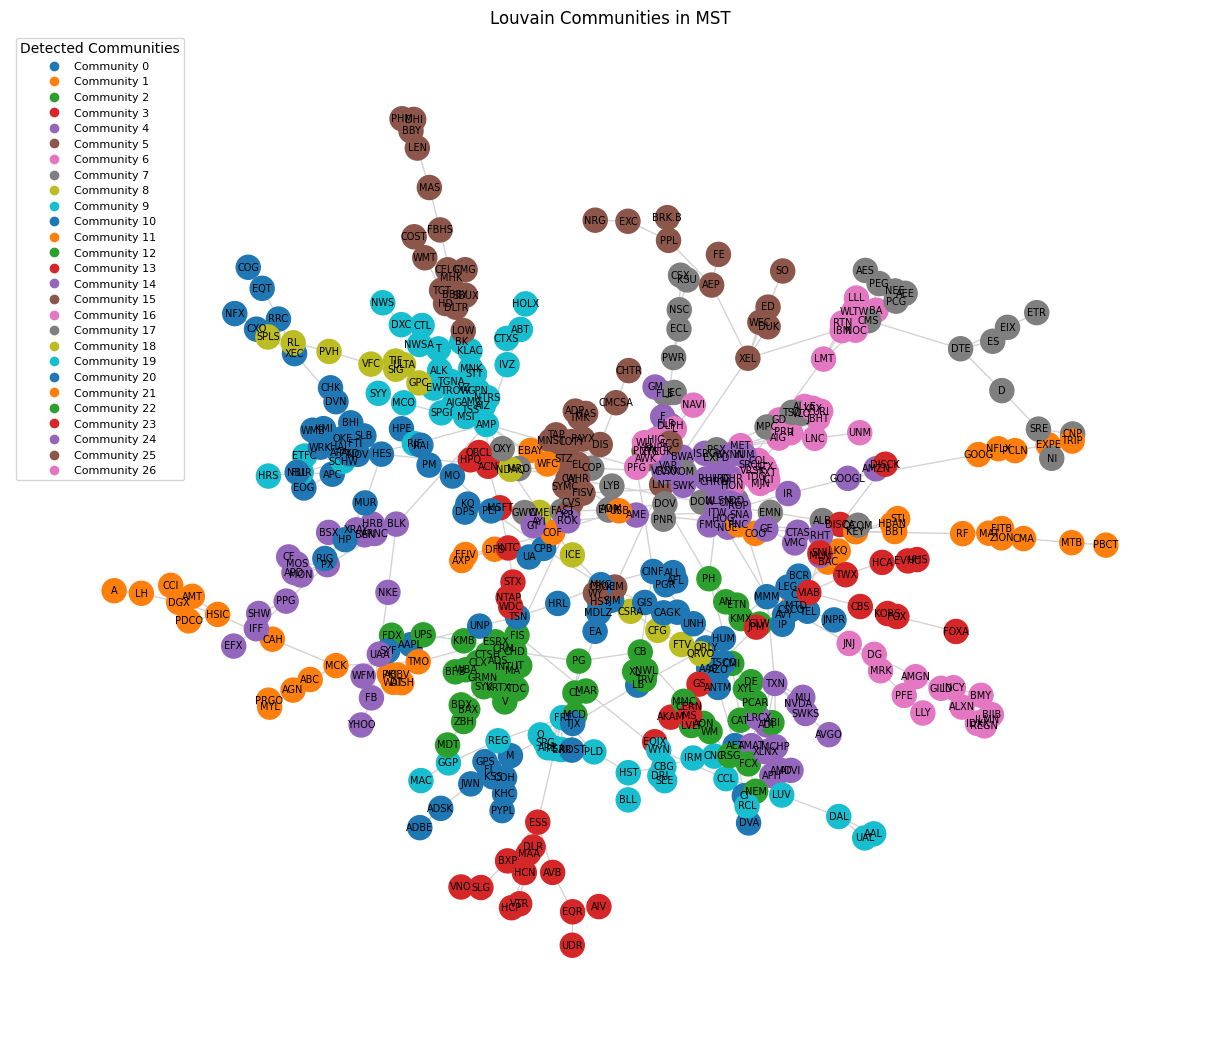

In [13]:
import matplotlib.pyplot as plt

# Generate color map for communities
communities = list(set(partition.values()))
community_colors = {cid: plt.cm.tab10(i % 10) for i, cid in enumerate(communities)}
node_colors = [community_colors[partition[n]] for n in mst.nodes()]

# Position using spring layout
pos = nx.spring_layout(mst, seed=42)

plt.figure(figsize=(12, 10))
nx.draw(mst, pos,
        node_color=node_colors,
        with_labels=True,
        node_size=300,
        font_size=7,
        edge_color='lightgray')

# Legend
for cid in communities:
    plt.plot([], [], color=community_colors[cid], marker='o', linestyle='', label=f"Community {cid}")
plt.legend(loc="best", fontsize=8, title="Detected Communities")
plt.title("Louvain Communities in MST")
plt.axis("off")
plt.show()

In [14]:
from sklearn.metrics import homogeneity_score, completeness_score

# True labels: sector of each stock
true_labels = [mst.nodes[n]['sector'] for n in mst.nodes()]
# Predicted labels: community id
pred_labels = [partition[n] for n in mst.nodes()]

h_score = homogeneity_score(true_labels, pred_labels)
c_score = completeness_score(true_labels, pred_labels)

print(f"Homogeneity: {h_score:.4f}")
print(f"Completeness: {c_score:.4f}")

Homogeneity: 0.5709
Completeness: 0.4004


Louvain community detection was applied to the MST of the stock correlation graph, resulting in 27 communities. The detected clusters were compared against sector labels using two metrics:
* Homogeneity: 0.5709
* Completeness: 0.4004

The moderate homogeneity indicates that many communities contain mostly one sector, but some mixing exists. The lower completeness suggests that several sectors are split across multiple communities. This outcome is expected, given that the MST simplifies the full correlation graph and captures only the strongest connections, limiting its ability to preserve full sector grouping.

# Question 5

# Question 6

# Question 7

# Question 8

# Question 9

# Question 10

# Question 11

# Question 12

# Question 13

# Question 14

# Question 15

# Question 16

# Question 17

# Question 18

# Question 19

# Question 20

# Question 21

# Question 22

# Question 23

# Question 24

# Define your task